In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk

In [2]:
### Classes: 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

In [2]:
## Data Loading and Splitting
data=pd.read_csv("../FaceRecognition.csv")
data=data.drop(columns='Unnamed: 0')
Train_data=data[data['X2306']=='Training'].drop(columns='X2306')
Test_data=data[data['X2306']=='PrivateTest'].drop(columns='X2306')
Train_labels=Train_data.iloc[:,0].values
Test_labels=Test_data.iloc[:,0].values
Train_data=Train_data.drop(columns='X1').values
Test_data=Test_data.drop(columns='X1').values


In [3]:
def vectortoimg(v,show=True):
    plt.imshow(v.reshape(48, 48),interpolation='None', cmap='gray')
    plt.axis('off')
    if show:
        plt.show()

In [4]:
### Applying PCA for Dimension Reduction
meanvector=np.mean(Train_data,axis=0)
Z_Train=Train_data-meanvector
C_Train=np.cov(Z_Train.T)  ## Check the shape, should be square matrix with dimensions as number of features : here 2304
Eigenvalues,Eigenvectors=np.linalg.eigh(C_Train)
print('Largest Eigen Value is at Last Index '+str(np.argmax(Eigenvalues)))  ## Largest Eigen Value is at the last index. So, Flipping is required   
row=Eigenvectors[-1,:];col=Eigenvectors[:,-1];
print("Row dot product value: Max/Min " + str(max(np.dot(C_Train,row)-(Eigenvalues[-1]*row)))) ## Rows are not eigen vectors
print ("Column dot product value: Max/Min"+str(max(np.dot(C_Train,col)-(Eigenvalues[-1]*col))))  #### matrix* EigenVector==EigenValue* EigenVector ,Therefore, Columns are EigenVectors
## Columns are Eigen Vectors. Taking Transpose and Inverse
Eigenvalues=np.flipud(Eigenvalues)
Eigenvectors=np.flipud(Eigenvectors.T)
row=Eigenvectors[0,:]
## Checking Again:
min(np.dot(C_Train,row)-(Eigenvalues[0]*row))  ## Rows are eigen vectors here 
np.allclose(np.dot(C_Train,row),Eigenvalues[0]*row)  ## Check 2  ## We finally got ordered Eigen Vectors and Eigen Values
prin_comp=np.dot(Z_Train,Eigenvectors.T)   ### We always have to find principle components this way for Training Data Set
print('shape of principle_comp_matrix is '+ str(prin_comp.shape))



Largest Eigen Value is at Last Index2303
Row dot product value: Max/Min 225060.78302759485
Column dot product value: Max/Min1.7462298274040222e-10
shape of principle_comp_matrix is (28709, 2304)


In [16]:
## Selecting Number of Components
cumulative_variance=[]
net_variance=[]
temp=0.0
E_sum=np.sum(Eigenvalues)
for i in Eigenvalues:
    temp=temp+i
    cumulative_variance.append(temp*100/E_sum)
    net_variance.append(i*100/E_sum)

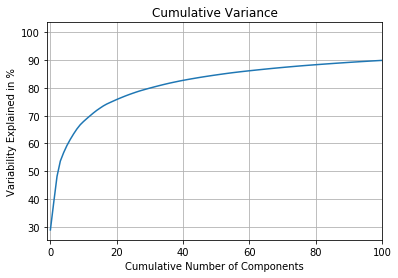

In [17]:
plt.plot(range(len(cumulative_variance)),cumulative_variance)
plt.title("Cumulative Variance")
plt.xlim(right=100,left=-1)
plt.xlabel("Cumulative Number of Components")
plt.ylabel("Variability Explained in %")
plt.grid()

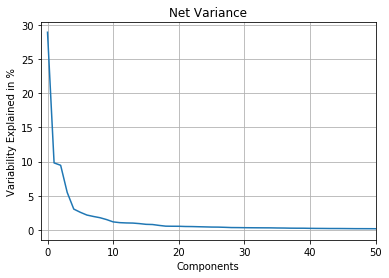

In [18]:
plt.plot(range(len(net_variance)),net_variance)
plt.xlim(right=50,left=-1)
plt.title("Net Variance")
plt.xlabel("Components")
plt.ylabel("Variability Explained in %")
plt.grid()

In [19]:
pca_num_components=len(list(filter(lambda x: x <= 75, cumulative_variance)))  ### 75% Variability Explained with 19 components

In [20]:
Train_pca=pd.DataFrame(prin_comp[:,:pca_num_components])

In [22]:
Train_pca.shape

(28709, 19)

In [23]:
Train_pca['labels']=Train_labels

In [30]:
#x=np.dot(prin_comp[:,:pca_num_components],Eigenvectors[:pca_num_components,:])+ meanvector

In [26]:
Train_pca['labels'].describe()

count    28709.000000
mean         3.317427
std          1.876632
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max          6.000000
Name: labels, dtype: float64

In [34]:
s = Train_pca['labels']
s.value_counts(normalize=False)

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: labels, dtype: int64

In [37]:
len(Train_pca[Train_pca['labels']==1])

436

In [42]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.8, random_state=0)

In [132]:
##### Linear Classifier ##########
### Encoding the Target Labels
Targets_six = np.zeros((Train_pca.shape[0], max(Train_labels)+1))
Targets_six[np.arange(Train_pca.shape[0]), Train_labels] = 1

### Preparing augmented matrix
xa=pd.DataFrame(Train_data)
xa.insert(0,column='ones',value=1)

#### Weights
weights_six=np.dot(np.linalg.pinv(xa.values),Targets_six)

### Training Error
pass_train=np.dot(xa,weights_six)
train_passed_labels=[]
for i in range(len(pass_train)):
    train_passed_labels.append(np.argmax(pass_train[i,:]))
train_passed_labels=np.array(train_passed_labels)

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(Train_labels,train_passed_labels,labels=[0,1,2,3,4,5,6])
ppv_table=cm/np.sum(cm,axis=0)
print('Desc order ppvs: ' + str(np.sort(ppv_table.diagonal())[::-1]))
print('Desc order ppv of classes: ' + str(np.argsort(ppv_table.diagonal())[::-1]))
print('PPV of any random seven class classifier: ' + str(1/7) )



Desc order ppvs: [0.92307692 0.5847569  0.48598131 0.48362919 0.47985897 0.46678134
 0.43641555]
Desc order ppv of classes: [1 5 2 0 3 6 4]
PPV of any random seven class classifier: 0.14285714285714285


In [131]:
## Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
class_weight=class_weight.compute_class_weight('balanced',np.unique(Train_labels),Train_labels)
class_weight = {key: value for (key, value) in zip(range(6),class_weight)}

#### Model ##########

logreg = LogisticRegression(C=1e10, solver='newton-cg', multi_class='multinomial',random_state=1234,class_weight=class_weight)
logreg.fit(Train_pca.iloc[:,:-1], Train_labels)

### Predict
log_train_pred=logreg.predict(Train_pca.iloc[:,:-1])

## Confusion Matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(Train_labels,log_train_pred,labels=[0,1,2,3,4,5,6])

#### PPV

ppv_table=cm/np.sum(cm,axis=0)
print('Desc order ppvs: ' + str(np.sort(ppv_table.diagonal())[::-1]))
print('Desc order ppv of classes: ' + str(np.argsort(ppv_table.diagonal())[::-1]))
print('PPV of any random seven class classifier: ' + str(1/7) )

Desc order ppvs: [0.40295067 0.30001834 0.27471894 0.26188525 0.21105528 0.18690096
 0.03449883]
Desc order ppv of classes: [3 5 4 6 0 2 1]
PPV of any random seven class classifier: 0.14285714285714285
